# Assignments - module 1

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vigji/python-cimec-2024/blob/main/assignments/Assignments_1.ipynb)

This notebook contains the assignments to complete for credits for the first module. 

**Submission**: Once you're happy with your solutions, send it to me in any form (email the file, share it through Colab/Google Drive, send me a link to your GitHub repo...).

**Deadline**: 5th of July 2024

**Evaluation**: There is no grade, but I will pass assignments that showcase a reasonable degree of understanding og the covered topics. Do your best, and feel free to ask for help if you are struggling! 

(Also, try to keep in mind not only the goal of the exercise, but also all the coding best practices we have been considering in the lectures.)

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## 0. Spike detection

In this exercise we will be playing around with some (dummy) electrophysiology recordings. You can use the function below to generate the data:

In [4]:
def generate_spike_trace(trace_length=60, firing_rate=1, noise_sigma = 0.05):
    """Function to generate a fake extracellular recording.
    
    Parameters
    ----------
        trace_length : float
            Duration of the recording in seconds.
        
        firing_rate : float
            Average firing rate of the neuron in Hz.
            
        noise_sigma : float
            Noise level.
            
            
    Returns:
    --------
        np.array
            Fake extracellular recording. 
    
    """
    np.random.seed(42)
    FS = 10000  # sampling frequency
    n = int(trace_length * FS)  # number of samples
    
    # Generate spike shape template as a difference of Gaussians.
    # A horrible bunch of magic numbers - do not imitate!
    x = np.arange(30)
    spike_template = np.exp(-(x - 10)**2/6) - np.exp(-(x - 12)**2/16)*0.8

    # Generate spike times from a gaussian distribution:
    spikes_times = np.random.poisson(firing_rate / FS, n)
    
    # Convolve dirac delta functions of spike times with spike template:
    trace = np.convolve(spikes_times, spike_template)[:n]

    # Add some gaussian noise:
    trace += np.random.normal(0, noise_sigma, n)
    
    return trace

### Exercise 0.0

Run the function below to generate an synthetic extracellular recording for a neuron. Make a nice plot with the trace; the neuron's spikes are the high peaks that appear above the noise! 

---

(_Optional_) If you want to make a plot with exact x coordinates in seconds, you should know that the trace is sampled at 10000 Hz (10000 points per second).

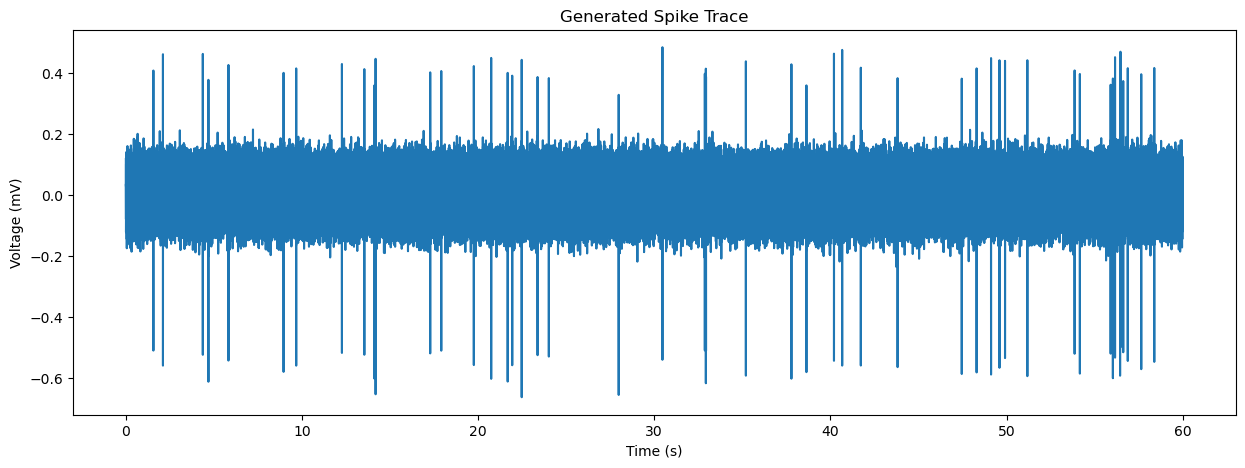

In [67]:
from random import sample
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Generate a spike trace
voltage_trace = generate_spike_trace()

sampling_rate = 10000
time_array = np.arange(0, len(voltage_trace)/sampling_rate, 1/sampling_rate)
# Plot the generated spike trace
plt.figure(figsize=(15, 5))
plt.plot(time_array, voltage_trace)
plt.title("Generated Spike Trace")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.show()



### Exercise 0.1

Write a function to detect spikes!
The function should take the trace as input, and return the index of each spike as the output (as the index, you should take the position of the spike maximum)

Hint: a good strategy to detect such events is to set a threshold, and look for elements above it. This will not be enough! each spike could have more than 1 point above the threshold, but you want to make sure you take only the spike peak! For this, you will probably need a loop.

Hint: do not start from writing the function. First debug your code running it in a cell, then move it to a function.

Hint: if you want, you can quickly check out the results you are getting by making a scatter plot of the detected spikes overimposed on the electrophysiology trace! (use as x of the dots the indexes of the spikes, and as y the hight of the trace at those indexes)

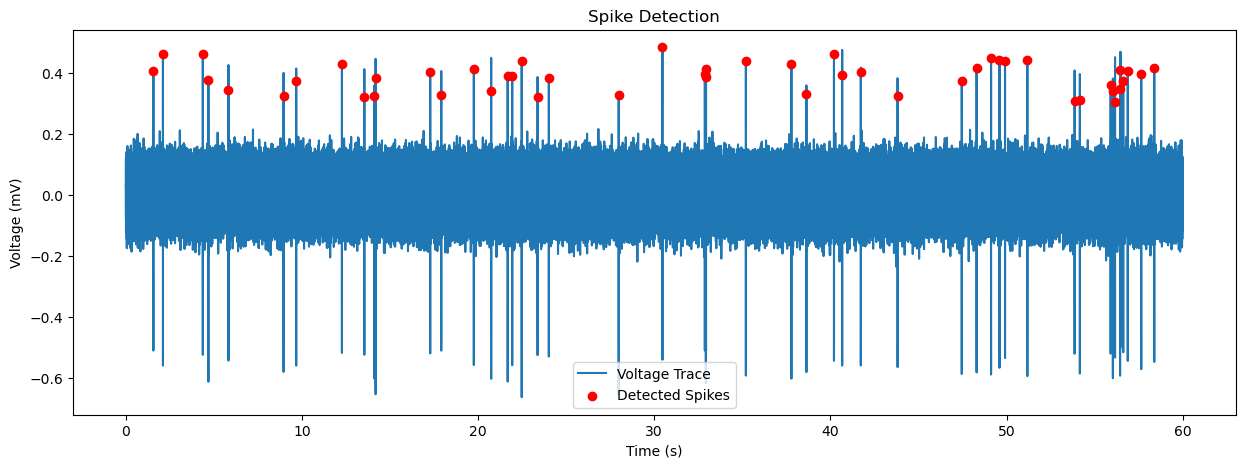

In [71]:
def detect_spikes(voltage_trace, threshold=0.3):
    """
    Detect spikes in a voltage trace based on a simple threshold.

    Parameters
    ----------
    voltage_trace : numpy.ndarray
        Array of voltage values.
    threshold : float
        Voltage threshold for spike detection.

    Returns
    -------
    spike_times : numpy.ndarray
        Indices of detected spikes.
    """
    spike_times = np.where(voltage_trace > threshold)[0]

    # filter out consecutive detections as they are multiple counts:
    spike_times = spike_times[np.insert(np.diff(spike_times) > 1, 0, True)]

    return spike_times

# Detect spikes in the generated voltage trace
spike_times = detect_spikes(voltage_trace)

# Plot the voltage trace with detected spikes

plt.figure(figsize=(15, 5))
plt.plot(time_array, voltage_trace, label='Voltage Trace')
plt.scatter(time_array[spike_times], voltage_trace[spike_times], c="r", label='Detected Spikes', zorder=100)
plt.title("Spike Detection")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.legend()
plt.show()

### Exercise 0.2

We now want to have a look at the shape of those spikes. For this, we will create a function that crops small chunks of the trace around each spike peak.

Write a `crop_event()` function that takes as inputs:
   - the recording array
   - the spike indexes
   - a `n_points_pad` variable specifying the number of points to include before and after the spike

And returns a matrix of shape `(n_spikes, n_points*2)` containing the trace chunks cropped around spike events! 

Hint: A good strategy coult be initialize an empty matrix and then fill it in a loop with the trace around the spikes.

**This function can be very useful in many contexts!** You can use it every time you want to crop a timeseries around events (e.g., EEG data or video kinematics data around some stimuli). So keep it at hand in the future!

---

(_Optional_) Pro challenge: Try to do it without for loops! if you construct a matrix with the indexes of the points you want to exctract from the trace, you can use it directly to index the trace!
For indexing in this way, you want to build a matrix that looks like this:
```
array([[...t0-2, t0-1, t0, t0+1, t0+2...],
       [...t1-2, t1-1, t1, t1+1, t1+2...],
       [...t2-2, t2-1, t2, t2+1, t2+2...],])
```
Where `t0`, `t1`, `t2`... are the indexes of each spike, and you take as many points before and after as specified by the `n_points_pad` paramenter. 

Building this matrix without loops is not trivial but it can be done nicely with numpy broadcasting!


In [76]:

import numpy as np
import matplotlib.pyplot as plt

def crop_trace(trace, spike_indexes, n_points_pad):
    n_spikes = len(spike_indexes)
    n_points = n_points_pad*2
    cropped = np.zeros((n_spikes, n_points))
    for i, spike in enumerate(spike_indexes):
        cropped[i] = trace[spike-n_points_pad:spike+n_points_pad]
    return cropped

cropped = crop_trace(voltage_trace, spike_times, 50)


In [78]:
# optional: no loops version
def crop_trace_vectorized(trace, spike_indexes, n_points_pad):
    # use only smart indexing, one line of code!
    spike_indexes = spike_indexes[:, None] + np.arange(-n_points_pad, n_points_pad)
    return trace[spike_indexes]

cropped_vectorized = crop_trace_vectorized(voltage_trace, spike_times, 50)

# check that the two functions give the same result:
print(np.allclose(cropped, cropped_vectorized))

True


### Exercise 0.3

Finally, make two subplots one close to the other. On the left, use `plt.matshow` to show the spike matrix. On the right,
plot each individual spike (rows of the matrix) using `plt.plot` with gray lines, and the average spike shape in red on top.

---

(Optional) If you want you can try to normalize the matrix before plotting by subtracting the average of each row (as we were doing for the daily temperatures)!

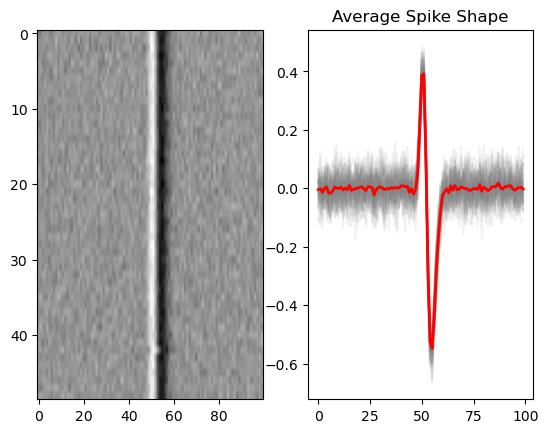

In [73]:
# Finally, make two subplots one close to the other. On the left, use `plt.matshow` to show the spike matrix. On the right,
# plot each individual spike (rows of the matrix) using `plt.plot` with gray lines, and the average spike shape in red on top.
# try to normalize the matrix before plotting by subtracting the average of each row (as we were doing for the daily temperatures)!

# Plot the cropped spike matrix in two subplots
plt.close("all")
plt.subplot(1, 2, 1)
plt.imshow(cropped, cmap='gray', aspect='auto')
plt.subplot(1, 2, 2)
plt.plot(cropped.T, color='gray', alpha=0.1)
plt.plot(cropped.mean(axis=0), color='red', linewidth=2)
plt.title("Average Spike Shape")
plt.show()


## 1. Real books data

After having appreciated how many books the universe of all possible books contains, let's now focus just on the reachable ones - and how much people like them! 

Here, we will download the information about about thousands volumns available on Amazon. Just a tiny fraction of Babel's books, but way more organized!

We will also get a dataset of users writing reviews, and a dataset of reviews.

### Exercise 1.0

Using, `pandas`, read the `.csv` files from the urls. The files contain the books, the ratings, and the user data.

Then, plot an histogram of all the ratings from all users, and another histogram with the age of the users:

In [16]:
users_df_url = "https://github.com/vigji/python-cimec-2024/raw/main/assignments/files/users.csv"
ratings_df_url = "https://github.com/vigji/python-cimec-2024/raw/main/assignments/files/ratings.csv"
books_df_url = "https://github.com/vigji/python-cimec-2024/raw/main/assignments/files/books.csv"


In [ ]:
users_df = pd.read_csv(users_df_url)
ratings_df = pd.read_csv(ratings_df_url)
books_df = pd.read_csv(books_df_url)

In [79]:
books_df.head()

,ISBN,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [80]:
ratings_df.head()

,user_id,ISBN,rating
0,276747,0060517794,9
1,276747,0671537458,9
2,276747,0679776818,8
3,276754,0684867621,8
4,276755,0451166892,5


In [81]:
users_df.head()

,user_id,age,country
0,2,18.0,usa
1,4,17.0,portugal
2,6,61.0,usa
3,10,26.0,spain
4,11,14.0,australia


[Text(0.5, 1.0, 'Age Distribution'),
 Text(0.5, 0, 'Age'),
 Text(0, 0.5, 'Count')]

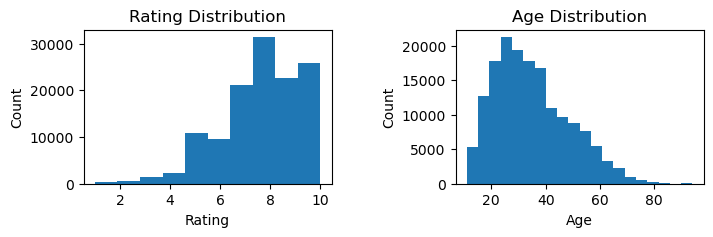

In [96]:
# histogram of all ratings and user ages:
f, axs = plt.subplots(1, 2, figsize=(8, 2), gridspec_kw={"wspace": 0.5})
axs[0].hist(ratings_df['rating'], bins=10)
axs[0].set(title='Rating Distribution', xlabel='Rating', ylabel='Count')

axs[1].hist(users_df['age'], bins=20)
axs[1].set(title='Age Distribution', xlabel='Age', ylabel='Count')


### Exercise 1.1

Using the ratings dataframe, compute the average rating for each book, and count how many reviews each book had. Then:
- find out which book had the highest number of reviews.
- find out which book had the highest average rating - but include only books that have at least 100 reviews!


Finally, look for the titles that correspond to those book codes (ISBNs are unique book codes).

In [29]:
# ount book with most ratings:
most_rated_book_isbn = ratings_df['ISBN'].value_counts().idxmax()

# Get the title of the most rated book:
most_rated_book_title = books_df[books_df['ISBN'] == most_rated_book_isbn]['title'].values[0]
print(f"The most rated book is: {most_rated_book_title}")

The most rated book is: Wild Animus


In [34]:
# filter reviews for ISBNs with more than 100 ratings:
min_n_reviews = 100
popular_books = ratings_df['ISBN'].value_counts()[ratings_df['ISBN'].value_counts() > min_n_reviews].index 
filtered_ratings_df = ratings_df[ratings_df['ISBN'].isin(popular_books)]

# highest rated book:
highest_rated_book_isbn = filtered_ratings_df.groupby('ISBN')['rating'].mean().idxmax()
highest_rated_book_title = books_df[books_df['ISBN'] == highest_rated_book_isbn]['title'].values[0]
print(f"The highest rated book is: {highest_rated_book_title}")

The highest rated book is: Harry Potter and the Prisoner of Azkaban (Book 3)


### Exercise 1.2

Let's get even more specific! Let's find the preferences of users in specific countries and with different ages.

Use the users DataFrame to select only italian users under 40 years old. Then, go back to the reviews dataframe and filter only reviews from those users. Compute the average ratings (include only books that have at least 3 reviews) and sort the ISBNs by average rating. Finally, find the books corresponding to each ISBN code to get which books got the best ratings in this coort of people!

(_Optional_): from the users DataFrame generate a list of all the countries present in the dataset. Then, find the highest rated book in each one of those countries.

In [65]:
country_to_filter = 'italy'
age_to_filter = 40
min_n_reviews = 3

def print_top_scoring(users_df, books_df, ratings_df, country_to_filter, 
                      age_to_filter=40, min_n_reviews=3):

    # select country readers under 40:
    country_readers_df = users_df[(users_df['country'] ==country_to_filter) & (users_df['age'] < age_to_filter)]

    # filter reviews from italian readers under 40:
    filtered_ratings_df = ratings_df[ratings_df['user_id'].isin(country_readers_df['user_id'])]

    # further filters for books with more than 3 ratings:
    pop_books_idx = filtered_ratings_df['ISBN'].value_counts()[filtered_ratings_df['ISBN'].value_counts() > min_n_reviews].index

    # sort valid books by average rating:
    pop_books_df = filtered_ratings_df[filtered_ratings_df['ISBN'].isin(pop_books_idx)]
    pop_books_avg_rating_df = pop_books_df.groupby('ISBN')["rating"].mean()  # average rating per book

    # map ISBN to book titles:
    sorted_scores = pop_books_avg_rating_df.sort_values(ascending=False)  # sort ISBNs (as indexes) by average rating
    sorted_titles = books_df.set_index('ISBN')['title'].loc[sorted_scores.index]  # use sorted index to sort df with titles

    if len(sorted_scores) == 0:
        print("No books found with the specified criteria.")
        return
    
    for i, (isbn, title) in enumerate(zip(sorted_scores.index, sorted_titles)):
        print(f"{i+1}. {title} - {sorted_scores[isbn]:.2f}")

print_top_scoring(users_df, books_df, ratings_df, country_to_filter, age_to_filter, min_n_reviews)

1. Il Piccolo Principe - 9.50
2. Il Piccolo Principe Prince Italn - 9.27
3. Novocento, Un Monologo - 8.58
4. Almost blue (Stile libero) - 8.50
5. Oceano Mare - 8.45
6. Garzanti - Gli Elefanti: Gabbiano Jonathan Livingston - 8.29
7. The Journeys of Frodo - 8.25
8. The Color Purple - 8.25
9. George W. Bushisms : The Slate Book of The Accidental Wit and Wisdom of our 43rd President - 8.20
10. iI Paradiso Degli Orchi - 8.00
11. Due di due (Bestsellers) - 7.80
12. Garzanti - Gli Elefanti: La Famiglia Winshaw - 7.75
13. Seta - 7.62
14. Io Non Ho Paura - 7.33
15. Siddharta Romanzo Versione Di M Mila - 7.33
16. E Venne Chiamata Due Cuori - 7.25
17. Senza Sangue - 6.80
18. Ax: An 87th Precinct Mystery - 6.60
19. D Amore E Ombra - 6.00


In [66]:
# optional: all countries:
countries = users_df['country'].unique()

for country in countries:
    print(f"\nTop rated books in {country}:")
    print_top_scoring(users_df, books_df, ratings_df, country, age_to_filter, min_n_reviews)
    print("\n")



Top rated books in usa:
1. 52 Ways to Simplify Your Life (52 Decks) - 10.00
2. The Sneetches and Other Stories - 10.00
3. Oh, the Thinks You Can Think! (I Can Read It All by Myself Beginner Books) - 10.00
4. Classics of Western Literature: Bloom County 1986-1989 - 10.00
5. The Main Corpse (Culinary Mysteries (Paperback)) - 10.00
6. Halloween: Romantic Art and Customs Of Yesteryear Postcard Book - 10.00
7. The Giving Tree - 10.00
8. The Little Zen Companion - 10.00
9. Anne of Green Gables (Bantam Starfire Book) - 10.00
10. TOLKIEN MAGNETIC POSTCARDS(tm) 12 Full-color Magnetic Postcards to Send or Save - 10.00
11. Adventures of Huckleberry Finn (Dover Thrift Editions) - 10.00
12. The Hobbit - 10.00
13. The Ultimate Seduction (Harlequin Blaze, No 61) - 10.00
14. The Complete Book of Essential Oils and Aromatherapy - 10.00
15. Christine - 10.00
16. The Official Scrabble Players Dictionary (Third Edition) - 10.00
17. Fat Girls and Lawn Chairs - 10.00
18. The Lorax - 10.00
19. More Than Com